In [1]:
import os
import re
import sys
import dataset
from scipy.stats import nanmean
from scipy.optimize import curve_fit
import math
#import numpy
#import matplotlib.pyplot as plt
%pylab inline


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
def au2kcal(x):
    if type(x) is not list: 
        x = [ x ]
        islist=0
        if x==[None]:
            return None
    else:
        islist=1
    for i in range(len(x)):
        x[i]=x[i]*627.50960803
    if not islist:
        x=x[0]
    return x

In [3]:
def extapolateTau(taus,energies,errors):
    def func(x, a,b):
        if type(x) is not list: 
            x = [ x ]
            islist=0
        else:
            islist=1
        res=[0]*len(x)
        for i in range(len(x)):
            res[i]=a*x[i]+b
        if islist==0:
            res=res[0]
        return res
    
    popt, pcov = curve_fit(func, taus, energies, sigma=errors, absolute_sigma=True, check_finite=True)
    perr = np.sqrt(np.diag(pcov))
    
#    plt.figure()
#    plt.errorbar(taus, au2kcal(energies), yerr=au2kcal(errors), fmt='ro')
#    t=arange(0.0, 0.01, 0.001)
#    s = au2kcal(func(t,popt[0],popt[1]))
#    plt.plot(t, s)
#    plt.autoscale(enable=True, axis=u'both', tight=True)
#    ax=plt.gca().get_ybound()
#    plt.ylim([ax[0],ax[0]+10])
#    plt.show()
    
    return[popt[1],perr[1]]

In [4]:
def extapolateTauQuad(taus,energies,errors):
    def func(x, a,b,c):
        if type(x) is not list: 
            x = [ x ]
            islist=0
        else:
            islist=1
        res=[0]*len(x)
        for i in range(len(x)):
            res[i]=a*x[i]**2+b*x[i]+c
        if islist==0:
            res=res[0]
        return res
    
    popt, pcov = curve_fit(func, taus, energies, sigma=errors, absolute_sigma=True, check_finite=True)
    perr = np.sqrt(np.diag(pcov))
    
#    plt.figure()
#    plt.errorbar(taus, au2kcal(energies), yerr=au2kcal(errors), fmt='ro')
#    t=arange(0.0, 0.01, 0.001)
#    s = au2kcal(func(t,popt[0],popt[1],popt[2]))
#    plt.plot(t, s)
#    plt.autoscale(enable=True, axis=u'both', tight=True)
#    ax=plt.gca().get_ybound()
#    plt.ylim([ax[0],ax[0]+10])
#    plt.show()
 
    return[popt[2],perr[2]]

In [5]:
moleculeDB='3dMLBE20_JTCT11-2036_2015.db' #/home/kdd/test/3dMLBE20_JTCT11-2036_2015.db'
jobDB2='jobDB2.db'#gaussian results (TransitionMetalMolecules2)
jobDB='jobDB.db'#gamess results (TransitionMetalMolecules)
#get list of compounds
with dataset.connect('sqlite:///'+moleculeDB) as DB3d:
    compoundList=[]
    compoundListMol=[]
    for table in ['atoms', 'dimers']:
        for molecule in DB3d[table]:
            if table=='atoms':
                compoundList.append(molecule['atom'])
            elif table=='dimers':
                compoundList.append(molecule['compound'])
                compoundListMol.append(molecule['compound'])


In [6]:
dfttypList=['none','PBE','B3LYP','B97-1']
typList=['DFT_gaussian','EMIN_casino_gaussian','DMC_casino_gaussian','DFT_gamess','EMIN_casino_gamess','DMC_casino_gamess' ]
dtList=[0.002,0.005,0.008]
energy=numpy.zeros((len(compoundList),len(dfttypList)*len(typList)))
error=numpy.zeros((len(compoundList),len(dfttypList)*len(typList)))
variance=numpy.zeros((len(compoundList),len(dfttypList)*len(typList)))
dissocEnergy=numpy.zeros((len(compoundListMol),len(dfttypList)*len(typList)))
dissocError=numpy.zeros((len(compoundListMol),len(dfttypList)*len(typList)))
dissocEnergyQuad=numpy.zeros((len(compoundListMol),len(dfttypList)*len(typList)))
dissocErrorQuad=numpy.zeros((len(compoundListMol),len(dfttypList)*len(typList)))
dissocEnergyExp=numpy.zeros(len(compoundListMol))
energyExtrap=numpy.zeros((len(compoundList),3*len(dfttypList)*len(typList)))
errorExtrap=numpy.zeros((len(compoundList),3*len(dfttypList)*len(typList)))
dissocEnergyExtrap=numpy.zeros((len(compoundListMol),3*len(dfttypList)*len(typList)))
dissocErrorExtrap=numpy.zeros((len(compoundListMol),3*len(dfttypList)*len(typList)))


In [7]:
#get dft energy results gaussian
typ=0
for compound in range(len(compoundList)):
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='gaussian_stabCheck2'
        jobRecord['compound']=compoundList[compound]        

        with dataset.connect('sqlite:///'+jobDB2) as DBdata:
            result=DBdata['data'].find_one(**jobRecord)

        if result['status']=='Done':
            energy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(result['energy'])
            error[compound,dfttyp+len(dfttypList)*typ]=au2kcal(result['error'])
            variance[compound,dfttyp+len(dfttypList)*typ]=result['variance']
        else:
            energy[compound,dfttyp+len(dfttypList)*typ]=None
            error[compound,dfttyp+len(dfttypList)*typ]=0.0
            variance[compound,dfttyp+len(dfttypList)*typ]=None


In [8]:
#get dft energy results gamess
typ=3
for compound in range(len(compoundList)):
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='gamessCasinoInt'
        jobRecord['compound']=compoundList[compound]        

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            result=DBdata['data'].find_one(**jobRecord)

        if result['status']=='Done':
            energy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(result['energy'])
            error[compound,dfttyp+len(dfttypList)*typ]=au2kcal(result['error'])
            variance[compound,dfttyp+len(dfttypList)*typ]=result['variance']
        else:
            energy[compound,dfttyp+len(dfttypList)*typ]=None
            error[compound,dfttyp+len(dfttypList)*typ]=0.0
            variance[compound,dfttyp+len(dfttypList)*typ]=None


In [9]:
#get dmc energy results extrapolated to tau=0 and at tau=[0.002,0.005,0.008] based on gaussian
typ=2
for compound in range(len(compoundList)):
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='casino'
        jobRecord['qmctyp']='vmc_dmc'
        jobRecord['compound']=compoundList[compound]

        with dataset.connect('sqlite:///'+jobDB2) as DBdata:
            results=DBdata['data'].find(**jobRecord)

        resultsExtrap=[]
        for result in results:
            if result['jastrowFrom']==-1:
                continue
            elif '_true' in result['symmetry']:
                continue
            else:
                with dataset.connect('sqlite:///'+jobDB2) as DBdata:
                    jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                if jastrowFrom['qmctyp']!='emin':
                    continue
                with dataset.connect('sqlite:///'+jobDB2) as DBdata:
                    jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                if jastrowFrom2['qmctyp']!='varmin':
                    continue
            resultsExtrap.append(result)
            
        for i in reversed(range(len(resultsExtrap))):
            if not resultsExtrap[i]['status'] in ["Done","LargeErrorbar2", "BadReblock", "LargeErrorbar"]:
                resultsExtrap.pop(i)
                
        if len(resultsExtrap)<2:
            energy[compound,dfttyp+len(dfttypList)*typ]=None
            error[compound,dfttyp+len(dfttypList)*typ]=0.0
        else: #extrapolate to zero Time
#            print([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))])
#            print([resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))])
#            print([resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
            [energy[compound,dfttyp+len(dfttypList)*typ], error[compound,dfttyp+len(dfttypList)*typ]]=\
            au2kcal(extapolateTau([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))]))
        #non extrapolated results
        energyExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ):len(dtList)*(dfttyp+len(dfttypList)*typ)+len(dtList)]=None
        errorExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ):len(dtList)*(dfttyp+len(dfttypList)*typ)+len(dtList)]=None
        for i in range(len(resultsExtrap)):
            if  resultsExtrap[i]['dt']==dtList[0]:
                dt=0
            elif resultsExtrap[i]['dt']==dtList[1]:
                dt=1
            elif resultsExtrap[i]['dt']==dtList[2]:
                dt=2
            energyExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ)+dt]=au2kcal(resultsExtrap[i]['energy'])
            errorExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ)+dt]=au2kcal(resultsExtrap[i]['error'])
       

In [10]:
#get dmc energy results extrapolated to tau=0 and at tau=[0.002,0.005,0.008] based on gamess
typ=5
for compound in range(len(compoundList)):
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='casino'
        jobRecord['qmctyp']='vmc_dmc'
        jobRecord['compound']=compoundList[compound]

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            results=DBdata['data'].find(**jobRecord)

        resultsExtrap=[]
        for result in results:
            if result['jastrowFrom']==-1:
                continue
            elif '_true' in result['symmetry']:
                continue
            else:
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                if jastrowFrom['qmctyp']!='emin':
                    continue
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                if jastrowFrom2['qmctyp']!='varmin':
                    continue
            resultsExtrap.append(result)
            
        for i in reversed(range(len(resultsExtrap))):
            if not resultsExtrap[i]['status'] in ["Done","LargeErrorbar2", "BadReblock"]:
                resultsExtrap.pop(i)
                
        if len(resultsExtrap)<2:
            energy[compound,dfttyp+len(dfttypList)*typ]=None
            error[compound,dfttyp+len(dfttypList)*typ]=0.0
        else: #extrapolate to zero Time
#            print([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))])
#            print([resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))])
#            print([resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
            [energy[compound,dfttyp+len(dfttypList)*typ], error[compound,dfttyp+len(dfttypList)*typ]]=\
            au2kcal(extapolateTau([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))]))
        #non extrapolated results
        energyExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ):len(dtList)*(dfttyp+len(dfttypList)*typ)+len(dtList)]=None
        errorExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ):len(dtList)*(dfttyp+len(dfttypList)*typ)+len(dtList)]=None
        for i in range(len(resultsExtrap)):
            if  resultsExtrap[i]['dt']==dtList[0]:
                dt=0
            elif resultsExtrap[i]['dt']==dtList[1]:
                dt=1
            elif resultsExtrap[i]['dt']==dtList[2]:
                dt=2
            energyExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ)+dt]=au2kcal(resultsExtrap[i]['energy'])
            errorExtrap[compound,len(dtList)*(dfttyp+len(dfttypList)*typ)+dt]=au2kcal(resultsExtrap[i]['error'])
       

/opt/rh/python27/root/usr/lib64/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


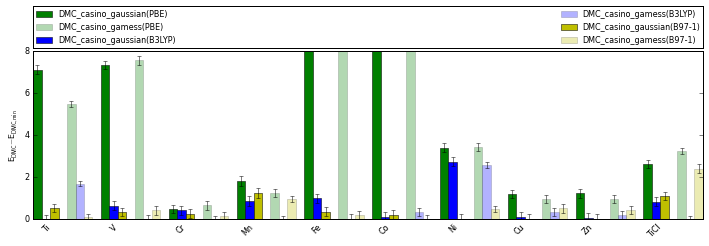

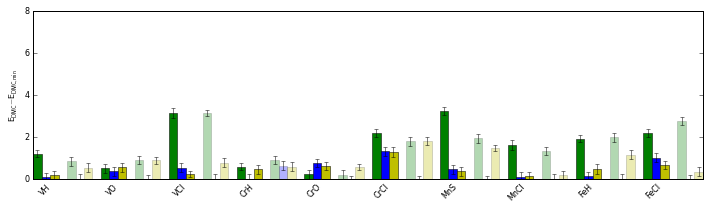

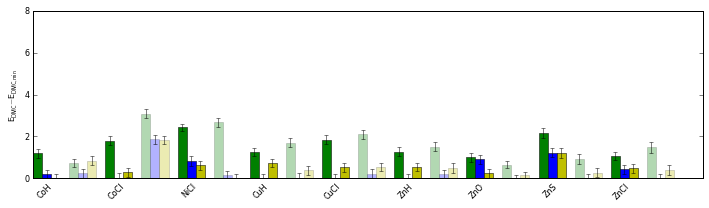

In [11]:
#plot DMC energy results results vs min DMC energy 
typForPlotList=[2,5]
molPerPlot=min(10, len(compoundList))
colors=['r','g','b','y','c','m']
opac=[1,0.3,0.3]
error_config = {'ecolor': '0.0', 'capsize': 2}
barwidth=1/(len(dfttypList)*len(typForPlotList)*1.0)
#barwidth=0.2
index = numpy.arange(molPerPlot)

j=0
for i in range(len(compoundList)):
    if compoundList[i] in ['H', 'O','S', 'Cl']:
        continue
    if j%molPerPlot==0:
        mycompoundList=[]
        fig, ax = plt.subplots(figsize=(12, 3))
    mycompoundList.append(compoundList[i])
    for dft in [1,2,3]:
        for tfp in range(len(typForPlotList)):
            typForPlot=typForPlotList[tfp]
            #print("{} {}".format(compoundList[i], dfttypList[dft]))
            #print("{}+/-{}".format(energy[i,typForPlot*(len(dfttypList))+dft]-min([nanmin(energy[i,tt*(len(dfttypList))+0:tt*(len(dfttypList))+5]) for tt in typForPlotList]), error[i,typForPlot*(len(dfttypList))+dft]))
            if j==0:
                rects=plt.bar(j%molPerPlot+(len(dfttypList)*tfp+dft)*barwidth,
                              (energy[i,typForPlot*(len(dfttypList))+dft]-min([nanmin(energy[i,tt*(len(dfttypList))+0:tt*(len(dfttypList))+5]) for tt in typForPlotList])), 
                              barwidth,
                              label=typList[typForPlot]+"("+dfttypList[dft]+")",
                              color=colors[dft],
                              alpha=opac[tfp],
                              linewidth=0.5,
                             )
            else:
                rects=plt.bar(j%molPerPlot+(len(dfttypList)*tfp+dft)*barwidth,
                              (energy[i,typForPlot*(len(dfttypList))+dft]-min([nanmin(energy[i,tt*(len(dfttypList))+0:tt*(len(dfttypList))+5]) for tt in typForPlotList])), 
                              barwidth,
                              color=colors[dft],
                              alpha=opac[tfp],
                              linewidth=0.5,
                             )
            errorb=plt.errorbar(j%molPerPlot+(len(dfttypList)*tfp+dft)*barwidth+barwidth/2.0, 
                                (energy[i,typForPlot*(len(dfttypList))+dft]-min([nanmin(energy[i,tt*(len(dfttypList))+0:tt*(len(dfttypList))+5]) for tt in typForPlotList])),
                                yerr=error[i,typForPlot*(len(dfttypList))+dft],
                                ecolor='k',
                                elinewidth=0.5, capsize=2
                               )
            plt.xticks(index+0.4, mycompoundList,  rotation=45, ha='right', fontsize=8)                                                                                                   
            plt.ylabel(r'$\mathrm{\mathsf{E_{DMC}-E_{DMC, min}}}$', fontsize=8)#, fontsize=12) 
            if j<molPerPlot:
                plt.legend(loc=3, bbox_to_anchor=(0., 1.02, 1., .102), ncol=2, mode="expand", borderaxespad=0., prop={'size':8})#,bbox_to_anchor=(1.05, 1), prop={'size':8})
            plt.ylim([0,4])
            plt.yticks(np.arange(0, 10, 2.0), fontsize=8)
            ax.xaxis.set_tick_params(width=0)
            #plt.autoscale(enable=True, axis=u'both', tight=True)
            if j%molPerPlot==molPerPlot-1 or i==len(compoundList)-1:
                fig.set_size_inches(12,3)
                plt.savefig('absE'+str(int(j/molPerPlot))+'.svg', format='svg', dpi=300)
    j+=1




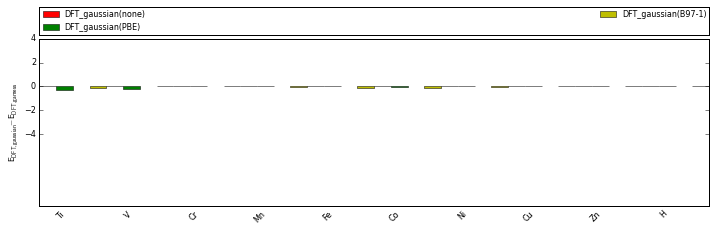

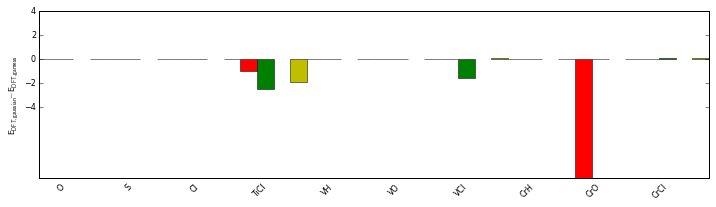

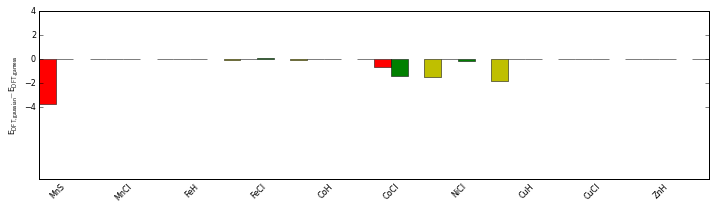

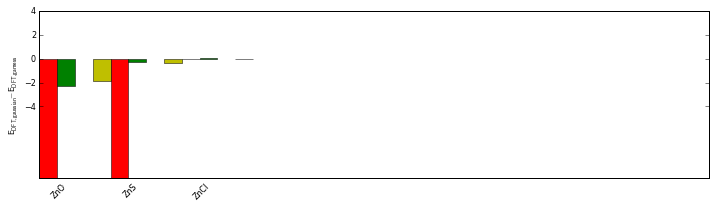

In [12]:
#plot DFT gaussian vs. DFT gamess
typForPlotList=[0]
typCompare=3
molPerPlot=min(10, len(compoundList))
colors=['r','g','b','y','c','m']
opac=[1,0.3,0.3]
error_config = {'ecolor': '0.0', 'capsize': 2}
barwidth=1/(len(dfttypList)*len(typForPlotList)*1.0)
#barwidth=0.2
index = numpy.arange(molPerPlot)

j=0
for i in range(len(compoundList)):
    #if compoundList[i] in ['H', 'O','S', 'Cl']:
    #    continue
    if j%molPerPlot==0:
        mycompoundList=[]
        fig, ax = plt.subplots(figsize=(12, 3))
    mycompoundList.append(compoundList[i])
    for tfp in range(len(typForPlotList)):
        typForPlot=typForPlotList[tfp]
        for dft in [0,1,3]:
            #print("{} {}".format(compoundList[i], dfttypList[dft]))
            #print("{}+/-{}".format(energy[i,typForPlot*(len(dfttypList))+dft]-min([nanmin(energy[i,tt*(len(dfttypList))+0:tt*(len(dfttypList))+5]) for tt in typForPlotList]), error[i,typForPlot*(len(dfttypList))+dft]))
            if j==0:
                rects=plt.bar(j%molPerPlot+(len(dfttypList)*tfp+dft)*barwidth,
                              (energy[i,typForPlot*(len(dfttypList))+dft]-energy[i,typCompare*(len(dfttypList))+dft]), 
                              barwidth,
                              label=typList[typForPlot]+"("+dfttypList[dft]+")",
                              color=colors[dft],
                              alpha=opac[tfp],
                              linewidth=0.5,
                             )
            else:
                rects=plt.bar(j%molPerPlot+(len(dfttypList)*tfp+dft)*barwidth,
                              (energy[i,typForPlot*(len(dfttypList))+dft]-energy[i,typCompare*(len(dfttypList))+dft]), 
                              barwidth,
                              color=colors[dft],
                              alpha=opac[tfp],
                              linewidth=0.5,
                             )
            errorb=plt.errorbar(j%molPerPlot+(len(dfttypList)*tfp+dft)*barwidth+barwidth/2.0, 
                                (energy[i,typForPlot*(len(dfttypList))+dft]-energy[i,typCompare*(len(dfttypList))+dft]), 
                                yerr=sqrt(error[i,typForPlot*(len(dfttypList))+dft]**2+error[i,typCompare*(len(dfttypList))+dft]**2),
                                ecolor='k',
                                elinewidth=0.5, capsize=2
                               )
            plt.xticks(index+0.4, mycompoundList,  rotation=45, ha='right', fontsize=8)                                                                                                   
            plt.ylabel(r'$\mathrm{\mathsf{E_{DFT, gaussian}-E_{DFT, gamess}}}$', fontsize=8)#, fontsize=12) 
            if j<molPerPlot:
                plt.legend(loc=3, bbox_to_anchor=(0., 1.02, 1., .102), ncol=2, mode="expand", borderaxespad=0., prop={'size':8})#,bbox_to_anchor=(1.05, 1), prop={'size':8})
            plt.ylim([-10,4])
            plt.yticks(np.arange(-4, 6, 2.0), fontsize=8)
            ax.xaxis.set_tick_params(width=0)
            #plt.autoscale(enable=True, axis=u'both', tight=True)
            if j%molPerPlot==molPerPlot-1 or i==len(compoundList)-1:
                fig.set_size_inches(12,3)
                plt.savefig('absE'+str(int(j/molPerPlot))+'.svg', format='svg', dpi=300)
    j+=1

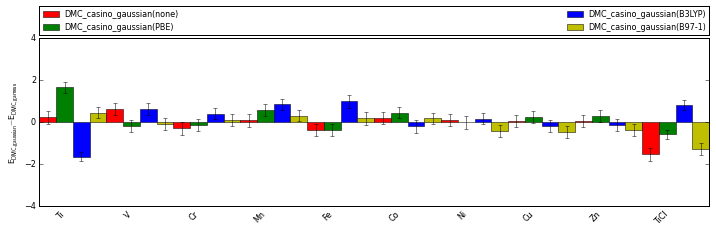

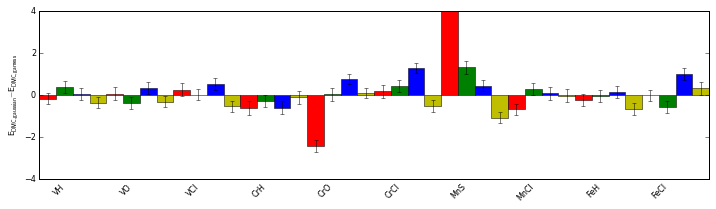

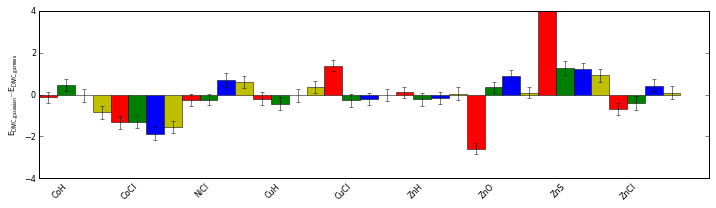

In [13]:
#plot DMC energy based on gaussian vs. DMC energy based on gamess
typForPlotList=[2]
typCompare=5
molPerPlot=min(10, len(compoundList))
colors=['r','g','b','y','c','m']
opac=[1,0.3,0.3]
error_config = {'ecolor': '0.0', 'capsize': 2}
barwidth=1/(len(dfttypList)*len(typForPlotList)*1.0)
#barwidth=0.2
index = numpy.arange(molPerPlot)

j=0
for i in range(len(compoundList)):
    if compoundList[i] in ['H', 'O','S', 'Cl']:
        continue
    if j%molPerPlot==0:
        mycompoundList=[]
        fig, ax = plt.subplots(figsize=(12, 3))
    mycompoundList.append(compoundList[i])
    for tfp in range(len(typForPlotList)):
        typForPlot=typForPlotList[tfp]
        for dft in [0,1,2,3]:
            #print("{} {}".format(compoundList[i], dfttypList[dft]))
            #print("{}+/-{}".format(energy[i,typForPlot*(len(dfttypList))+dft]-min([nanmin(energy[i,tt*(len(dfttypList))+0:tt*(len(dfttypList))+5]) for tt in typForPlotList]), error[i,typForPlot*(len(dfttypList))+dft]))
            if j==0:
                rects=plt.bar(j%molPerPlot+(len(dfttypList)*tfp+dft)*barwidth,
                              (energy[i,typForPlot*(len(dfttypList))+dft]-energy[i,typCompare*(len(dfttypList))+dft]), 
                              barwidth,
                              label=typList[typForPlot]+"("+dfttypList[dft]+")",
                              color=colors[dft],
                              alpha=opac[tfp],
                              linewidth=0.5,
                             )
            else:
                rects=plt.bar(j%molPerPlot+(len(dfttypList)*tfp+dft)*barwidth,
                              (energy[i,typForPlot*(len(dfttypList))+dft]-energy[i,typCompare*(len(dfttypList))+dft]), 
                              barwidth,
                              color=colors[dft],
                              alpha=opac[tfp],
                              linewidth=0.5,
                             )
            errorb=plt.errorbar(j%molPerPlot+(len(dfttypList)*tfp+dft)*barwidth+barwidth/2.0, 
                                (energy[i,typForPlot*(len(dfttypList))+dft]-energy[i,typCompare*(len(dfttypList))+dft]), 
                                yerr=sqrt(error[i,typForPlot*(len(dfttypList))+dft]**2+error[i,typCompare*(len(dfttypList))+dft]**2),
                                ecolor='k',
                                elinewidth=0.5, capsize=2
                               )
            plt.xticks(index+0.4, mycompoundList,  rotation=45, ha='right', fontsize=8)                                                                                                   
            plt.ylabel(r'$\mathrm{\mathsf{E_{DMC, gaussian}-E_{DMC, gamess}}}$', fontsize=8)#, fontsize=12) 
            if j<molPerPlot:
                plt.legend(loc=3, bbox_to_anchor=(0., 1.02, 1., .102), ncol=2, mode="expand", borderaxespad=0., prop={'size':8})#,bbox_to_anchor=(1.05, 1), prop={'size':8})
            plt.ylim([-4,4])
            plt.yticks(np.arange(-4, 6, 2.0), fontsize=8)
            ax.xaxis.set_tick_params(width=0)
            #plt.autoscale(enable=True, axis=u'both', tight=True)
            if j%molPerPlot==molPerPlot-1 or i==len(compoundList)-1:
                fig.set_size_inches(12,3)
                plt.savefig('absE'+str(int(j/molPerPlot))+'.svg', format='svg', dpi=300)
    j+=1

In [14]:
#get dissocE for DFT gaussian
typ=0
for compound in range(len(compoundListMol)):
                
    atoms=re.findall('[A-Z][^A-Z]*', compoundListMol[compound])
    
    experimentMol=DB3d['dimers'].find_one(compound=compoundListMol[compound])
    dissocEnergyExp[compound]=experimentMol['De(exp)[kcal/mol]']
    experimentAtom=[]
    for i in range(len(atoms)):
        experimentAtom.append(DB3d['atoms'].find_one(atom=atoms[i]))
                                       
                                       
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='gaussian_stabCheck2'
        jobRecord['compound']=compoundListMol[compound]   

        with dataset.connect('sqlite:///'+jobDB2) as DBdata:
            resultMol=DBdata['data'].find_one(**jobRecord)
        
        resultAtom=[]
        for i in range(len(atoms)):
            jobRecord['compound']=atoms[i]
            with dataset.connect('sqlite:///'+jobDB2) as DBdata:
                resultAtom.append(DBdata['data'].find_one(**jobRecord))
        if resultMol['status']=='Done' and all( [resultAtom[i]['status']=='Done' for i in range(len(atoms))]):
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMol['energy']+sum(resultAtom[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocError[compound,dfttyp+len(dfttypList)*typ]=0.0
        else:
            dissocEnergy[compound, dfttyp+len(dfttypList)*typ]=None
            dissocError[compound,dfttyp+len(dfttypList)*typ]=0.0

            

In [15]:
#get dissocE for DFT gamess
typ=3
for compound in range(len(compoundListMol)):
                
    atoms=re.findall('[A-Z][^A-Z]*', compoundListMol[compound])
    
    experimentMol=DB3d['dimers'].find_one(compound=compoundListMol[compound])
    dissocEnergyExp[compound]=experimentMol['De(exp)[kcal/mol]']
    experimentAtom=[]
    for i in range(len(atoms)):
        experimentAtom.append(DB3d['atoms'].find_one(atom=atoms[i]))
                                       
                                       
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='gamessCasinoInt'
        jobRecord['compound']=compoundListMol[compound]   

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            resultMol=DBdata['data'].find_one(**jobRecord)
        
        resultAtom=[]
        for i in range(len(atoms)):
            jobRecord['compound']=atoms[i]
            with dataset.connect('sqlite:///'+jobDB) as DBdata:
                resultAtom.append(DBdata['data'].find_one(**jobRecord))
        if resultMol['status']=='Done' and all( [resultAtom[i]['status']=='Done' for i in range(len(atoms))]):
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMol['energy']+sum(resultAtom[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocError[compound,dfttyp+len(dfttypList)*typ]=0.0
        else:
            dissocEnergy[compound, dfttyp+len(dfttypList)*typ]=None
            dissocError[compound,dfttyp+len(dfttypList)*typ]=0.0


In [16]:
#get dissocE for dmc (zero tau extrap) for casino based on gaussian
typ=2
for compound in range(len(compoundListMol)):
    atoms=re.findall('[A-Z][^A-Z]*', compoundListMol[compound])
    
    experimentMol=DB3d['dimers'].find_one(compound=compoundListMol[compound])
    dissocEnergyExp[compound]=experimentMol['De(exp)[kcal/mol]']
    experimentAtom=[]
    for i in range(len(atoms)):
        experimentAtom.append(DB3d['atoms'].find_one(atom=atoms[i]))
        
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='casino'
        jobRecord['qmctyp']='vmc_dmc'
        jobRecord['compound']=compoundListMol[compound]

        with dataset.connect('sqlite:///'+jobDB2) as DBdata:
            results=DBdata['data'].find(**jobRecord)

        resultsExtrap=[]
        resultMol={}
        resultMolQuad={}
        for result in results:
            if result['jastrowFrom']==-1:
                continue
            elif '_true' in result['symmetry']:
                continue
            else:
                with dataset.connect('sqlite:///'+jobDB2) as DBdata:
                    jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                if jastrowFrom['qmctyp']!='emin':
                    continue
                with dataset.connect('sqlite:///'+jobDB2) as DBdata:
                    jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                if jastrowFrom2['qmctyp']!='varmin':
                    continue
            resultsExtrap.append(result)
        for i in reversed(range(len(resultsExtrap))):
            if not resultsExtrap[i]['status'] in ["Done","LargeErrorbar2", "BadReblock", "LargeErrorbar"]:
                resultsExtrap.pop(i)

        if len(resultsExtrap)!=3:
            resultMol['status']='Error'
        else: #extrapolate to zero Time
            [resultMol['energy'], resultMol['error']]=\
            extapolateTau([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
            resultMol['status']='Done'
        if len(resultsExtrap)<3:
            resultMolQuad['status']='Error'
        else:
            [resultMolQuad['energy'], resultMolQuad['error']]=\
            extapolateTauQuad([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
            resultMolQuad['status']='Done'
            
        resultAtom=[]
        resultAtomQuad=[]
        for i in range(len(atoms)):
            resultsExtrap=[]
            resultAtomI={}
            resultAtomIQuad={}
            jobRecord['compound']=atoms[i]
            with dataset.connect('sqlite:///'+jobDB2) as DBdata:
                results=DBdata['data'].find(**jobRecord)
                for result in results:
                    if result['jastrowFrom']==-1:
                        continue
                    elif '_true' in result['symmetry']:
                        continue
                    else:
                        with dataset.connect('sqlite:///'+jobDB2) as DBdata:
                            jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                        if jastrowFrom['qmctyp']!='emin':
                            continue
                        with dataset.connect('sqlite:///'+jobDB2) as DBdata:
                            jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                        if jastrowFrom2['qmctyp']!='varmin':
                            continue
                    resultsExtrap.append(result)
                for i in reversed(range(len(resultsExtrap))):
                    if not resultsExtrap[i]['status'] in ["Done","LargeErrorbar2", "BadReblock", "LargeErrorbar"]:
                        resultsExtrap.pop(i)

                if len(resultsExtrap)!=3:
                    resultAtomI['status']='Error'
                    resultAtom.append(resultAtomI)
                else: #extrapolate to zero Time
                    [resultAtomI['energy'], resultAtomI['error']]=\
                    extapolateTau([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
                    resultAtomI['status']='Done'  
                    resultAtom.append(resultAtomI)
                if len(resultsExtrap)<3:
                    resultAtomIQuad['status']='Error'
                    resultAtomQuad.append(resultAtomIQuad)
                else:
                    [resultAtomIQuad['energy'], resultAtomIQuad['error']]=\
                    extapolateTauQuad([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
                    resultAtomIQuad['status']='Done'  
                    resultAtomQuad.append(resultAtomIQuad)
        #print(compoundListMol[compound])
        if resultMol['status']=='Done' and all( [resultAtom[i]['status']=='Done' for i in range(len(atoms))]):
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMol['energy']+sum(resultAtom[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocError[compound,dfttyp+len(dfttypList)*typ]=au2kcal(sqrt(resultMol['error']*resultMol['error']+sum(resultAtom[i]['error']*resultAtom[i]['error'] for i in range(len(atoms)))))
        else:
            #print("{} {} {}".format(resultMol['status'], resultAtom[0]['status'], resultAtom[1]['status']))
            dissocEnergy[compound, dfttyp+len(dfttypList)*typ]=None
            dissocError[compound, dfttyp+len(dfttypList)*typ]=None
        if resultMolQuad['status']=='Done' and all( [resultAtomQuad[i]['status']=='Done' for i in range(len(atoms))]):           
            dissocEnergyQuad[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMolQuad['energy']+sum(resultAtomQuad[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergyQuad[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocErrorQuad[compound,dfttyp+len(dfttypList)*typ]=au2kcal(sqrt(resultMolQuad['error']*resultMolQuad['error']+sum(resultAtomQuad[i]['error']*resultAtomQuad[i]['error'] for i in range(len(atoms)))))
        else:
            dissocEnergyQuad[compound,dfttyp+len(dfttypList)*typ]=None
            dissocErrorQuad[compound,dfttyp+len(dfttypList)*typ]=None

In [17]:
#get dissocE for dmc (zero tau extrap) for casino based on gamess
typ=5
for compound in range(len(compoundListMol)):
    atoms=re.findall('[A-Z][^A-Z]*', compoundListMol[compound])
    
    experimentMol=DB3d['dimers'].find_one(compound=compoundListMol[compound])
    dissocEnergyExp[compound]=experimentMol['De(exp)[kcal/mol]']
    experimentAtom=[]
    for i in range(len(atoms)):
        experimentAtom.append(DB3d['atoms'].find_one(atom=atoms[i]))
        
    for dfttyp in range(len(dfttypList)):
        jobRecord={}
        jobRecord['dfttyp']=dfttypList[dfttyp]
        jobRecord['scftyp']='UHF'
        jobRecord['basisXMLFiles']='["BFD_Library_noPseudoH.xml", "aug-cc-pVTZ-DK_Diffuse.xml"]'
        jobRecord['basisNames']='["vtz", "aug-cc-pVTZ-DK_Diffuse"]'
        jobRecord['executingProgram']='casino'
        jobRecord['qmctyp']='vmc_dmc'
        jobRecord['Nu']=4
        jobRecord['Nchi']=4
        jobRecord['Nf']=2
        jobRecord['slaterGeneratingCode']='gamessCasinoInt'
        jobRecord['compound']=compoundListMol[compound]

        with dataset.connect('sqlite:///'+jobDB) as DBdata:
            results=DBdata['data'].find(**jobRecord)

        resultsExtrap=[]
        resultMol={}
        resultMolQuad={}
        for result in results:
            if result['jastrowFrom']==-1:
                continue
            elif '_true' in result['symmetry']:
                continue
            else:
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                if jastrowFrom['qmctyp']!='emin':
                    continue
                with dataset.connect('sqlite:///'+jobDB) as DBdata:
                    jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                if jastrowFrom2['qmctyp']!='varmin':
                    continue
            resultsExtrap.append(result)
        for i in reversed(range(len(resultsExtrap))):
            if not resultsExtrap[i]['status'] in ["Done","LargeErrorbar2", "BadReblock"]:
                resultsExtrap.pop(i)

        if len(resultsExtrap)!=3:
            resultMol['status']='Error'
        else: #extrapolate to zero Time
            [resultMol['energy'], resultMol['error']]=\
            extapolateTau([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
            resultMol['status']='Done'
        if len(resultsExtrap)<3:
            resultMolQuad['status']='Error'
        else:
            [resultMolQuad['energy'], resultMolQuad['error']]=\
            extapolateTauQuad([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                         [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
            resultMolQuad['status']='Done'
            
        resultAtom=[]
        resultAtomQuad=[]
        for i in range(len(atoms)):
            resultsExtrap=[]
            resultAtomI={}
            resultAtomIQuad={}
            jobRecord['compound']=atoms[i]
            with dataset.connect('sqlite:///'+jobDB) as DBdata:
                results=DBdata['data'].find(**jobRecord)
                for result in results:
                    if result['jastrowFrom']==-1:
                        continue
                    elif '_true' in result['symmetry']:
                        continue
                    else:
                        with dataset.connect('sqlite:///'+jobDB) as DBdata:
                            jastrowFrom=DBdata['data'].find_one(id=result['jastrowFrom'])
                        if jastrowFrom['qmctyp']!='emin':
                            continue
                        with dataset.connect('sqlite:///'+jobDB) as DBdata:
                            jastrowFrom2=DBdata['data'].find_one(id=jastrowFrom['jastrowFrom'])
                        if jastrowFrom2['qmctyp']!='varmin':
                            continue
                    resultsExtrap.append(result)
                for i in reversed(range(len(resultsExtrap))):
                    if not resultsExtrap[i]['status'] in ["Done","LargeErrorbar2", "BadReblock"]:
                        resultsExtrap.pop(i)

                if len(resultsExtrap)!=3:
                    resultAtomI['status']='Error'
                    resultAtom.append(resultAtomI)
                else: #extrapolate to zero Time
                    [resultAtomI['energy'], resultAtomI['error']]=\
                    extapolateTau([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
                    resultAtomI['status']='Done'  
                    resultAtom.append(resultAtomI)
                if len(resultsExtrap)<3:
                    resultAtomIQuad['status']='Error'
                    resultAtomQuad.append(resultAtomIQuad)
                else:
                    [resultAtomIQuad['energy'], resultAtomIQuad['error']]=\
                    extapolateTauQuad([resultsExtrap[i]['dt'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['energy'] for i in range(len(resultsExtrap))],
                                 [resultsExtrap[i]['error'] for i in range(len(resultsExtrap))])
                    resultAtomIQuad['status']='Done'  
                    resultAtomQuad.append(resultAtomIQuad)
        #print(compoundListMol[compound])
        if resultMol['status']=='Done' and all( [resultAtom[i]['status']=='Done' for i in range(len(atoms))]):
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMol['energy']+sum(resultAtom[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergy[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocError[compound,dfttyp+len(dfttypList)*typ]=au2kcal(sqrt(resultMol['error']*resultMol['error']+sum(resultAtom[i]['error']*resultAtom[i]['error'] for i in range(len(atoms)))))
        else:
            #print("{} {} {}".format(resultMol['status'], resultAtom[0]['status'], resultAtom[1]['status']))
            print resultMol['status']
            print resultMol
            print [resultAtom[i]['status'] for i in range(len(atoms))]
            dissocEnergy[compound, dfttyp+len(dfttypList)*typ]=None
            dissocError[compound, dfttyp+len(dfttypList)*typ]=None
        if resultMolQuad['status']=='Done' and all( [resultAtomQuad[i]['status']=='Done' for i in range(len(atoms))]):           
            dissocEnergyQuad[compound,dfttyp+len(dfttypList)*typ]=au2kcal(-resultMolQuad['energy']+sum(resultAtomQuad[i]['energy'] for i in range(len(atoms))))
            #correct energy for SO coupling:
            dissocEnergyQuad[compound,dfttyp+len(dfttypList)*typ]+=(-experimentMol['ESo(fromCAS)[kcal/mol]']+
                                             sum(experimentAtom[i]['E_SO [kcal/mol]'] for i in range(len(atoms))))
            dissocErrorQuad[compound,dfttyp+len(dfttypList)*typ]=au2kcal(sqrt(resultMolQuad['error']*resultMolQuad['error']+sum(resultAtomQuad[i]['error']*resultAtomQuad[i]['error'] for i in range(len(atoms)))))
        else:
            dissocEnergyQuad[compound,dfttyp+len(dfttypList)*typ]=None
            dissocErrorQuad[compound,dfttyp+len(dfttypList)*typ]=None

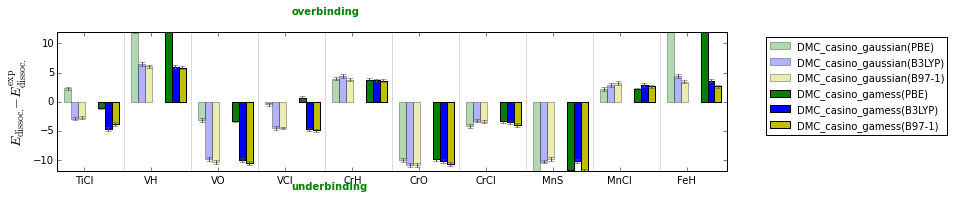

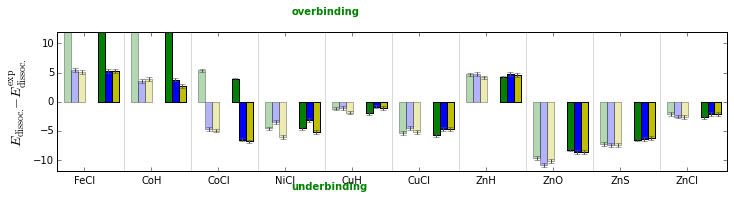

In [18]:
#plot dissoc energy results DMC
typForPlot=[2,5]
molPerPlot=min(11, len(compoundListMol))
colors=['r','g','b','y','c','m']
edgecolors=['r','g','b','y','c','m']
opac=[0.3,1,0.5,0.3,1,0.5]
error_config = {'ecolor': '0.3'}
barwidth=1/(4*len(typForPlot)*1.2)
#barwidth=0.2
index = numpy.arange(molPerPlot)

for l in range(int(ceil(float(len(compoundListMol))/molPerPlot))):#range(int(len(compoundListMol)/molPerPlot)+1):
    a=l*(molPerPlot-1)
    b=min((l+1)*(molPerPlot-1), len(compoundListMol))
    fig, ax = plt.subplots(figsize=(13, 6))
    for i in range(len(typForPlot)):
        for j in range(4):
            if j==0:
                continue
            rects=plt.bar(index[0:b-a]+(i*(4)+j)*barwidth+0.1*4*len(typForPlot)*barwidth*i,
                          (dissocEnergy[a:b,typForPlot[i]*(len(dfttypList))+j]-dissocEnergyExp[a:b]), 
                          barwidth,
                          label=typList[typForPlot[i]]+"("+dfttypList[j]+")",
                          color=colors[j],
                          alpha=opac[i],
                          linewidth=1,
                          yerr=dissocError[a:b,typForPlot[i]*(len(dfttypList))+j],
                          error_kw=error_config,)
    for k in range(b-a):
        plt.axvline(x=k, color='0.85')
    plt.xticks(index+0.4, compoundListMol[a:b])
    #plt.xlabel('Molecules, Methods')                                                                                                     
    plt.ylabel(r'$E_\mathrm{dissoc.}-E_\mathrm{dissoc.}^\mathrm{exp}$', fontsize=14) 
    if l==0:
        #plt.title('dissoc. energies grouped by molecules and methods')   
        plt.legend(loc=2,bbox_to_anchor=(1.05, 1), prop={'size':10})#(loc='best',prop={'size':8})
    plt.autoscale( enable=True,axis=u'both', tight=True)
    ax.text(real(molPerPlot-4)/2.0, 15, "overbinding", fontsize=10,color='green',fontweight='bold')
    ax.text(real(molPerPlot-4)/2.0, -15, "underbinding", fontsize=10,color='green',fontweight='bold')
    ylim([-12,12])
    xlim([0,molPerPlot-1])
    fig.set_size_inches(12,2.5)
    plt.savefig('dissocE'+str(l)+'.svg', format='svg', dpi=300)

In [19]:
#print the energy differences for DMC for casino
typ=2
for compound in range(len(compoundListMol)):
    print(compoundListMol[compound])
    print(dissocEnergy[compound,typ*(len(dfttypList)):typ*len(dfttypList)+4]-dissocEnergyExp[compound])
    print(dissocError[compound,typ*(len(dfttypList)):typ*len(dfttypList)+4])

TiCl
[-3.38605911  2.2683142  -2.94506171 -2.74637045]
[ 0.28776394  0.28727159  0.28205585  0.30033113]
VH
[  1.20240887  12.15519384   6.48548483   6.09073633]
[ 0.27918955  0.26780422  0.3006649   0.26250677]
VO
[-38.72833669  -3.13511311  -9.92007854 -10.39158369]
[ 0.30319147  0.29613164  0.3306483   0.28717471]
VCl
[-8.09858034 -0.48551726 -4.49204051 -4.53632494]
[ 0.33057073  0.31211243  0.32185653  0.2532333 ]
CrH
[-9.68762182  3.96173197  4.39305426  3.79234459]
[ 0.32116891  0.27486372  0.28869071  0.31185986]
CrO
[-44.42382179 -10.0726357  -10.90824671 -10.90424357]
[ 0.30185449  0.2922492   0.29947285  0.29671405]
CrCl
[-16.3059254   -4.17800038  -3.25061329  -3.42497377]
[ 0.32321632  0.2951339   0.30293556  0.32519956]
MnS
[-33.13462116 -12.16587305 -10.31876929  -9.92218119]
[ 0.30000673  0.30997837  0.31506296  0.33005241]
MnCl
[ 3.50963106  2.18914782  2.86518945  3.17922941]
[ 0.29848171  0.32611044  0.32365156  0.33809055]
FeH
[ -1.62943138  12.6363324    4.42297109

In [20]:
#print the energy differences for DFT
typ=0
for compound in range(len(compoundListMol)):
    print(compoundListMol[compound])
    print(dissocEnergy[compound,typ*(len(dfttypList)):typ*len(dfttypList)+4]-dissocEnergyExp[compound])
    print(dissocError[compound,typ*(len(dfttypList)):typ*len(dfttypList)+4])

TiCl
[-19.16654504  11.282936    -2.34635551  -6.58738547]
[ 0.  0.  0.  0.]
VH
[ -9.74920951  20.40250338  12.53228215   3.97635421]
[ 0.  0.  0.  0.]
VO
[-112.21813226   21.01968487  -11.40470231  -16.17582428]
[ 0.  0.  0.  0.]
VCl
[-23.47155032  10.18316138  -5.02601527  -9.56482358]
[ 0.  0.  0.  0.]
CrH
[-18.54811849   5.96092672   8.88583084   9.35019933]
[ 0.  0.  0.  0.]
CrO
[-82.89547854  10.11396098  -7.6897659   -0.73901837]
[ 0.  0.  0.  0.]
CrCl
[-26.23176818  -1.85423094  -4.76593934   0.20374179]
[ 0.  0.  0.  0.]
MnS
[-46.82595253  18.91693349  -4.72888525  -4.27579144]
[ 0.  0.  0.  0.]
MnCl
[-8.37509886  8.16363473 -4.75154909 -9.09333563]
[ 0.  0.  0.  0.]
FeH
[-13.2417483   18.25742167  12.86366812  11.25653108]
[ 0.  0.  0.  0.]
FeCl
[-8.06294778  6.80598086 -2.63883135 -5.26626164]
[ 0.  0.  0.  0.]
CoH
[-22.87718252  16.65983521  11.03630709   8.50193486]
[ 0.  0.  0.  0.]
CoCl
[-30.84999491   8.64287448  -3.82805261  -1.26231191]
[ 0.  0.  0.  0.]
NiCl
[-72.656

In [21]:
#calculate variance in the dissoc energy for DFT and DMC after DFT (without HF):
var=zeros(6)

for typ in [0,2,3,5]:
    n=0
    molNan=0
    for compound in range(len(compoundListMol)):
        if any(np.isnan(dissocEnergy[compound, 1:4])) or any(np.isnan(dissocEnergy[compound, 11:14])):
            molNan+=1
            continue
        else:
            var[typ]+=sum((dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]
                       -mean(dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]))**2)
            n+=1
            print(compoundListMol[compound])
            print(sqrt(sum((dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]
                       -mean(dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]))**2)/3))
    var[typ]=var[typ]/(n*3-n)

print(var)

TiCl
7.62373713678
VH
6.70789469842
VO
16.5247638745
VCl
8.44526655783
CrH
1.50029149316
CrO
7.32630529124
CrCl
2.03881850517
MnS
11.0415001383
MnCl
7.32921179078
FeH
2.99421546107
FeCl
5.18380926682
CoH
3.40911277307
CoCl
5.37710956327
NiCl
3.58565120435
CuH
0.672180352608
CuCl
3.00954019916
ZnH
1.37257983748
ZnO
5.92045510379
ZnS
4.11599334423
ZnCl
2.54136352152
TiCl
2.41214125276
VH
2.77046068236
VO
3.31519126816
VCl
1.89921716527
CrH
0.252890643087
CrO
0.392970658947
CrCl
0.40242286574
MnS
0.9777086366
MnCl
0.413106784558
FeH
4.12230579753
FeCl
4.16232742926
CoH
5.14819772419
CoCl
4.81903527417
NiCl
1.04161966167
CuH
0.362328282948
CuCl
0.372628107845
ZnH
0.254110899719
ZnO
0.523986365292
ZnS
0.119542534153
ZnCl
0.235811070224
TiCl
7.52077372737
VH
6.79606666889
VO
16.8054668352
VCl
7.86162613879
CrH
1.49643609084
CrO
7.62287919273
CrCl
2.18395421098
MnS
11.2151186595
MnCl
7.38213613562
FeH
3.03968864484
FeCl
5.25863762273
CoH
3.42665800004
CoCl
5.65112483526
NiCl
4.39623921536
CuH

In [22]:
#calculate variance in the dissoc energy for DFT and DMC after DFT (without HF) and without VO, VH, and FeH, FeCl, CoH, CoCl(bad PBE):
var=zeros(6)
for typ in [0,2,3,5]:
    n=0
    molNan=0
    for compound in range(len(compoundListMol)):
        if any(np.isnan(dissocEnergy[compound, 1:4])) or any(np.isnan(dissocEnergy[compound, 11:14])):
            molNan+=1
            continue
        if 'V' in compoundListMol[compound] or 'Fe' in compoundListMol[compound] or 'Co' in compoundListMol[compound]:
            continue
        else:
            var[typ]+=sum((dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]
                       -mean(dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]))**2)
            n+=1
            #print(compoundListMol[compound])
            #print(sqrt(sum((dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]
            #           -mean(dissocEnergy[compound, 1+typ*len(dfttypList):4+typ*len(dfttypList)]))**2)/3))
    print(n)
    var[typ]=var[typ]/(n*3-n)

print(var)

13
13
13
13
[ 43.44664505   0.           1.04878349  46.24181246   0.           0.53351063]


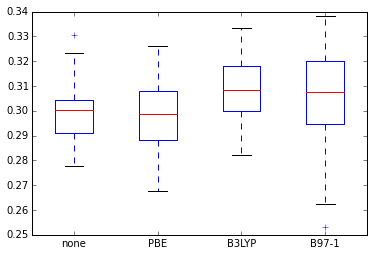

In [23]:
#analyze errorbars of dissocEnergy casino
typ=2
boxplot(dissocError[:,typ*len(dfttypList):4+typ*len(dfttypList)])
plt.xticks([1,2,3,4], dfttypList);

In [24]:
#calculate all mean unsigned errors
for i in [0,2,3,5]:#range(len(typList)):
    for j in range(len(dfttypList)):
        print("{} {}: {}".format(typList[i],dfttypList[j],nanmean(abs(dissocEnergy[:,j+i*len(dfttypList)]-dissocEnergyExp))))
        print(np.count_nonzero(~np.isnan(dissocEnergy[:,j+i*len(dfttypList)])))


DFT_gaussian none: 30.9707263884
20
DFT_gaussian PBE: 8.58890011816
20
DFT_gaussian B3LYP: 7.21531964876
20
DFT_gaussian B97-1: 5.89563458859
20
DMC_casino_gaussian none: 11.6515235679
20
DMC_casino_gaussian PBE: 6.61537907074
20
DMC_casino_gaussian B3LYP: 5.43327690764
20
DMC_casino_gaussian B97-1: 5.51244736887
20
DFT_gamess none: 35.152901637
20
DFT_gamess PBE: 8.37499005305
20
DFT_gamess B3LYP: 7.94827286465
20
DFT_gamess B97-1: 6.26428939509
20
DMC_casino_gamess none: 11.1736197825
20
DMC_casino_gamess PBE: 6.3891722223
20
DMC_casino_gamess B3LYP: 5.29770708029
20
DMC_casino_gamess B97-1: 5.40296786968
20


In [25]:
dissocEnergy

array([[  81.63345496,  112.082936  ,   98.45364449,   94.21261453,
           0.        ,    0.        ,    0.        ,    0.        ,
          97.41394089,  103.0683142 ,   97.85493829,   98.05362955,
          80.63531622,  109.82825162,   95.97439137,   92.38551978,
           0.        ,    0.        ,    0.        ,    0.        ,
          95.45375722,   99.74407792,   96.12512965,   96.96652928],
       [  41.65079049,   71.80250338,   63.93228215,   55.37635421,
           0.        ,    0.        ,    0.        ,    0.        ,
          52.60240887,   63.55519384,   57.88548483,   57.49073633,
          41.65078869,   72.01942697,   63.80668985,   55.37302008,
           0.        ,    0.        ,    0.        ,    0.        ,
          51.78369414,   64.10239242,   57.37063163,   57.22404839],
       [  38.78186774,  172.01968487,  139.59529769,  134.82417572,
           0.        ,    0.        ,    0.        ,    0.        ,
         112.27166331,  147.86488689,  141.079

In [26]:
#calculate all mean signed errors
for i in [0,2,3,5]:#range(len(typList)):
    for j in range(len(dfttypList)):
        print("{} {}: {}".format(typList[i],dfttypList[j],nanmean(dissocEnergy[:,j+i*len(dfttypList)]-dissocEnergyExp)))
        print(np.count_nonzero(~np.isnan(dissocEnergy[:,j+i*len(dfttypList)])))


DFT_gaussian none: -30.9707263884
20
DFT_gaussian PBE: 7.79366146239
20
DFT_gaussian B3LYP: -2.36372803808
20
DFT_gaussian B97-1: -2.3110854332
20
DMC_casino_gaussian none: -10.2860103347
20
DMC_casino_gaussian PBE: 0.582638169734
20
DMC_casino_gaussian B3LYP: -2.24496212254
20
DMC_casino_gaussian B97-1: -2.54993895923
20
DFT_gamess none: -35.152901637
20
DFT_gamess PBE: 7.4432819373
20
DFT_gamess B3LYP: -3.18726086127
20
DFT_gamess B97-1: -2.65844040466
20
DMC_casino_gamess none: -9.96564030787
20
DMC_casino_gamess PBE: 0.498264417584
20
DMC_casino_gamess B3LYP: -2.30622035775
20
DMC_casino_gamess B97-1: -2.68209357927
20


In [27]:
#calculate  standard deviation of the mean of the errors
for i in [0,2,3,5]:#range(len(typList)):
    for j in range(len(dfttypList)):
        mue=nanmean(abs(dissocEnergy[:,j+i*len(dfttypList)]-dissocEnergyExp))
        n=0
        var=0
        for k in range(len(compoundListMol)):
            if isnan(dissocEnergy[k,j+i*len(dfttypList)]):
                continue
            n+=1
            var+=(abs(dissocEnergy[k,j+i*len(dfttypList)]-dissocEnergyExp[k])-mue)**2
        if not n==0:
            print("{} {}: {}".format(typList[i],dfttypList[j],sqrt(var/(n-1)/n)))
            print(np.count_nonzero(~np.isnan(dissocEnergy[:,j+i*len(dfttypList)])))


DFT_gaussian none: 6.25675474333
20
DFT_gaussian PBE: 1.57916722262
20
DFT_gaussian B3LYP: 0.869364368837
20
DFT_gaussian B97-1: 0.941925224734
20
DMC_casino_gaussian none: 2.86321876477
20
DMC_casino_gaussian PBE: 1.02660685355
20
DMC_casino_gaussian B3LYP: 0.659994244618
20
DMC_casino_gaussian B97-1: 0.630674895505
20
DFT_gamess none: 6.96470755771
20
DFT_gamess PBE: 1.58095802527
20
DFT_gamess B3LYP: 0.90972092385
20
DFT_gamess B97-1: 0.955697485044
20
DMC_casino_gamess none: 2.77523549907
20
DMC_casino_gamess PBE: 1.03660667931
20
DMC_casino_gamess B3LYP: 0.602394815594
20
DMC_casino_gamess B97-1: 0.673038129588
20


In [28]:
#calculate corrected sample standard deviation of the errors
for i in [0,2,3,5]:#range(len(typList)):
    for j in range(len(dfttypList)):
        mue=nanmean(abs(dissocEnergy[:,j+i*len(dfttypList)]-dissocEnergyExp))
        n=0
        var=0
        for k in range(len(compoundListMol)):
            if isnan(dissocEnergy[k,j+i*len(dfttypList)]):
                continue
            n+=1
            var+=(abs(dissocEnergy[k,j+i*len(dfttypList)]-dissocEnergyExp[k])-mue)**2
        
        print("{} {}: {}".format(typList[i],dfttypList[j],sqrt(var/(n-1))))
        print(np.count_nonzero(~np.isnan(dissocEnergy[:,j+i*len(dfttypList)])))


DFT_gaussian none: 27.9810578493
20
DFT_gaussian PBE: 7.06225051522
20
DFT_gaussian B3LYP: 3.88791565187
20
DFT_gaussian B97-1: 4.21241766445
20
DMC_casino_gaussian none: 12.8047035849
20
DMC_casino_gaussian PBE: 4.59112542143
20
DMC_casino_gaussian B3LYP: 2.95158399145
20
DMC_casino_gaussian B97-1: 2.8204638761
20
DFT_gamess none: 31.1471190849
20
DFT_gamess PBE: 7.07025922815
20
DFT_gamess B3LYP: 4.06839565257
20
DFT_gamess B97-1: 4.27400908497
20
DMC_casino_gamess none: 12.411230459
20
DMC_casino_gamess PBE: 4.63584600175
20
DMC_casino_gamess B3LYP: 2.69399151392
20
DMC_casino_gamess B97-1: 3.00991801842
20


In [29]:
#calculate mean errors for single Det character mols:
for i in [0,2,3,5]:#range(len(typList)):
    for j in range(len(dfttypList)):
        print("{} {}: {}".format(typList[i],dfttypList[j],nanmean([abs(dissocEnergy[k,j+i*len(dfttypList)]-dissocEnergyExp[k]) for k in range(len(compoundListMol)) if compoundListMol[k] in ['CuCl', 'ZnH', 'ZnS', 'ZnCl', 'CrCl', 'MnCl', 'FeCl']])))
        print(np.count_nonzero(~np.isnan([dissocEnergy[k,j+i*len(dfttypList)]for k in range(len(compoundListMol)) if compoundListMol[k] in ['CuCl', 'ZnH', 'ZnS', 'ZnCl', 'CrCl', 'MnCl', 'FeCl']])))


DFT_gaussian none: 15.206640811
7
DFT_gaussian PBE: 3.54217102304
7
DFT_gaussian B3LYP: 5.60964863756
7
DFT_gaussian B97-1: 4.02927041239
7
DMC_casino_gaussian none: 7.19608145412
7
DMC_casino_gaussian PBE: 5.7084728729
7
DMC_casino_gaussian B3LYP: 4.40672637686
7
DMC_casino_gaussian B97-1: 4.46940005357
7
DFT_gamess none: 17.7001654363
7
DFT_gamess PBE: 3.50041499013
7
DFT_gamess B3LYP: 5.96109790465
7
DFT_gamess B97-1: 4.08185574256
7
DMC_casino_gamess none: 5.77235242814
7
DMC_casino_gamess PBE: 5.51606111246
7
DMC_casino_gamess B3LYP: 4.24619557648
7
DMC_casino_gamess B97-1: 4.23013333378
7


In [30]:
#calculate mean errors for multi Det character mols:
for i in [0,2,3,5]:#range(len(typList)):
    for j in range(len(dfttypList)):
        print("{} {}: {}".format(typList[i],dfttypList[j],nanmean([abs(dissocEnergy[k,j+i*len(dfttypList)]-dissocEnergyExp[k]) for k in range(len(compoundListMol)) if not compoundListMol[k] in ['CuCl', 'ZnH', 'ZnS', 'ZnCl', 'CrCl', 'MnCl', 'FeCl']])))
        print(np.count_nonzero(~np.isnan([dissocEnergy[k,j+i*len(dfttypList)]for k in range(len(compoundListMol)) if not compoundListMol[k] in ['CuCl', 'ZnH', 'ZnS', 'ZnCl', 'CrCl', 'MnCl', 'FeCl']])))


DFT_gaussian none: 39.4590801608
13
DFT_gaussian PBE: 11.3063696309
13
DFT_gaussian B3LYP: 8.07991173171
13
DFT_gaussian B97-1: 6.90059991423
13
DMC_casino_gaussian none: 14.0506077831
13
DMC_casino_gaussian PBE: 7.10371317726
13
DMC_casino_gaussian B3LYP: 5.98603488575
13
DMC_casino_gaussian B97-1: 6.07408823096
13
DFT_gamess none: 44.5505288219
13
DFT_gamess PBE: 10.9997612408
13
DFT_gamess B3LYP: 9.0182901508
13
DFT_gamess B97-1: 7.43944597722
13
DMC_casino_gamess none: 14.0819945118
13
DMC_casino_gamess PBE: 6.85930897375
13
DMC_casino_gamess B3LYP: 5.86390558235
13
DMC_casino_gamess B97-1: 6.03449415824
13


In [31]:
#calculate mean errors for mols with exp error <1.2kcal/mol (['FeH', 'NiCl', 'CuCl', 'CoH', 'CrO', ZnH', 'ZnO', 'ZnS', 'ZnCl'])
for i in [0,2,3,5]:#range(len(typList)):
    for j in range(len(dfttypList)):
        print("{} {}: {}".format(typList[i],dfttypList[j],nanmean([abs(dissocEnergy[k,j+i*len(dfttypList)]-dissocEnergyExp[k]) for k in range(len(compoundListMol)) if not compoundListMol[k] in ['FeH', 'NiCl', 'CuCl', 'CoH', 'CrO','ZnH', 'ZnO', 'ZnS', 'ZnCl']])))
        print(np.count_nonzero(~np.isnan([dissocEnergy[k,j+i*len(dfttypList)]for k in range(len(compoundListMol)) if not compoundListMol[k] in ['FeH', 'NiCl', 'CuCl', 'CoH', 'CrO','ZnH', 'ZnO', 'ZnS', 'ZnCl']])))

DFT_gaussian none: 30.2218939934
11
DFT_gaussian PBE: 10.6305994807
11
DFT_gaussian B3LYP: 5.72869803797
11
DFT_gaussian B97-1: 6.21025086886
11
DMC_casino_gaussian none: 12.3956729038
11
DMC_casino_gaussian PBE: 5.56270285122
11
DMC_casino_gaussian B3LYP: 5.08496061188
11
DMC_casino_gaussian B97-1: 5.09740111851
11
DFT_gamess none: 30.7171523752
11
DFT_gamess PBE: 10.2249667418
11
DFT_gamess B3LYP: 6.40856284863
11
DFT_gamess B97-1: 6.49119876679
11
DMC_casino_gamess none: 11.664227758
11
DMC_casino_gamess PBE: 5.3158910789
11
DMC_casino_gamess B3LYP: 5.30934743392
11
DMC_casino_gamess B97-1: 5.5019006771
11
